In [42]:
%matplotlib widget

from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from math import exp

from typing import Callable
from montecarlo import monte_carlo, MonteCarloEstimate

In [43]:
# functions for simulating Geometric Brownian Motion (GBM)
MU = 0.05
SIGMA = 0.2
Y0 = 1


def bm_gen(T, dt, num_paths):
    """Simulate a single path of brownian motion

    Inputs
    ------
    T: floating point variable, greater than 0, final time 
    dt: time increment of the simulation

    Returns
    -------
    bmotion: single path of a brownian motion simulation (nsamples, npaths)
    """
    nsamples = int(np.ceil(T / dt)) + 1
    samples = np.random.randn(nsamples, num_paths) * np.sqrt(dt)
    samples[0] = 0.0
    bmotion = np.cumsum(samples, axis=0)
    return bmotion


def bm_f2c(T, dt, brownian_fine, M):
    """Extract a sample of a coarse brownian motion simulation from a fine brownian motion simulation"""

    nsamples = int(np.ceil(T/dt)) + 1
    npaths = brownian_fine.shape[1]
    brownian_coarse = np.zeros((nsamples, npaths))
    brownian_coarse[0, :] = brownian_fine[0, :]
    for ii in range(1, nsamples):
        delta = brownian_fine[ii * M, :] - brownian_fine[(ii-1)*M, :]
        brownian_coarse[ii, :] = brownian_coarse[ii-1, :] + delta
    return brownian_coarse


def euler_maruyama(b, h, y0, dt, T, bmotion):
    """Perform Euler Maruyama integration to integrate a one dimensional SDE

        dX = b(t, X) dt + h(t, X) dW

    Inputs
    ------
    b: function taking input of a single time and a vector of (Npaths) values X
    h: function taking input of a single time and a vector of (Npaths) values X
    y0: initial condition (Npaths, )
    dt: time step
    T: final time
    bmotion: a brownian motion simulation (Nsteps, Npaths) that is consistent with dt and T

    Returns
    -------
    times: time incrememnts
    paths: (Nsteps, npaths)
    """

    num_paths = y0.shape[0]
    assert bmotion.shape[1] >= num_paths, "Not enough brownian motions simulated"
    num_steps = int(np.ceil(T / dt)) + 1
    paths = np.zeros((num_steps, num_paths))
    paths[0, :] = y0
    times = np.zeros(num_steps)
    t = 0
    for ii in range(1, num_steps):
        paths[ii, :] = paths[ii-1, :] + b(t, paths[ii-1, :]) * dt + \
            h(t, paths[ii-1, :]) * (bmotion[ii, :] - bmotion[ii-1, :])
        t += dt
        times[ii] = t
    return times, paths


def gbm_analytic(y0, mu, sigma, t, bmotion):
    return y0 * np.exp((mu - (sigma**2)/2) * t + SIGMA * bmotion)


def bfunc(t, y):
    return MU * y


def hfunc(t, y):
    return SIGMA * y

Using simulations for Y(1)
Mean: 1.0361560835852415
Variance: 0.04283696418771708
Using analytic solution for Y(1) directly
Mean: 1.0363404082129664
Variance: 0.042921065330777684
Full analytic solution for Y(1)
Mean: 1.0512710963760241
Variance: 0.04510288078157963
MC estimator variance: 4.283696418771708e-05


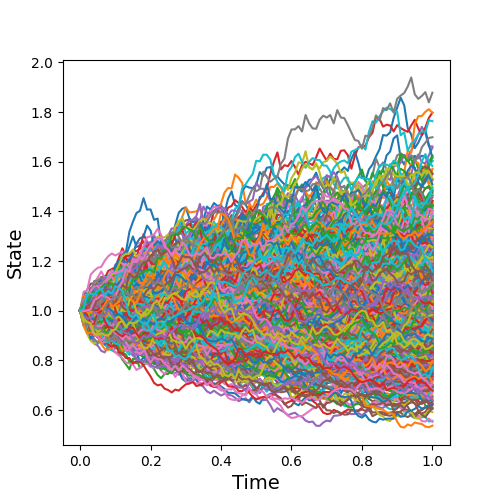

In [44]:
# 4.1 just simulate

def gbm_sim(dt, bmotion):
    y0 = np.ones((bmotion.shape[1]))  # start at 1
    return euler_maruyama(bfunc, hfunc, y0, dt, T, bmotion)


num_paths = 1000
T = 1
dt = 0.01
bmotion = bm_gen(T, dt, num_paths)
times, states = gbm_sim(dt, bmotion)
mean_y1 = np.mean(states[-1, :])  # this is basically the MC estimate
var_y1 = np.var(states[-1, :])
print(f"Using simulations for Y(1)\nMean: {mean_y1}\nVariance: {var_y1}")
mean_y1_analytic = np.mean(gbm_analytic(Y0, MU, SIGMA, T, bmotion[-1, :]))
var_y1_analytic = np.var(gbm_analytic(Y0, MU, SIGMA, T, bmotion[-1, :]))
print(
    f"Using analytic solution for Y(1) directly\nMean: {mean_y1_analytic}\nVariance: {var_y1_analytic}")

# full analytic solution without any samples, refer to report for derivation:
exp1 = exp(MU - SIGMA**2/2)
exp_norm_var = 1 * SIGMA**2
norm_exp_mean = exp(SIGMA**2 / 2)
norm_exp_var = (exp(SIGMA**2) - 1) * exp(SIGMA**2)
Y1_mean = exp1 * norm_exp_mean
Y1_var = exp1**2 * norm_exp_var
print(f"Full analytic solution for Y(1)\nMean: {Y1_mean}\nVariance: {Y1_var}")

print(f"MC estimator variance: {var_y1/num_paths}")

plt.figure(figsize=(5, 5))
plt.plot(times, states)
plt.xlabel('Time', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.savefig('figs/4.1.svg')

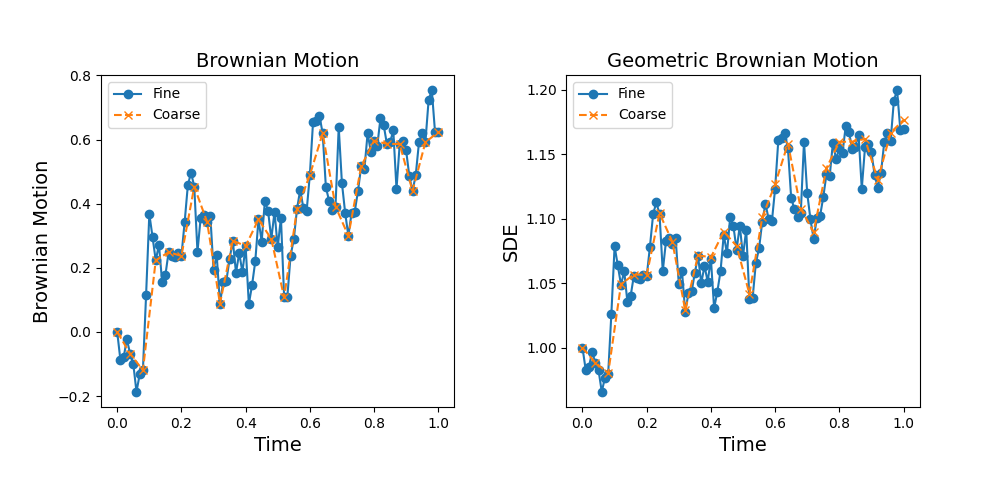

In [45]:
# 4.2 simulate both fine and coarse

def gbm_sim_fine_coarse(dt_fine, bmotion_fine):
    _, states_fine = gbm_sim(dt_fine, bmotion_fine)
    bmotion_coarse = bm_f2c(T, dt_fine * M, bmotion_fine, M)
    _, states_coarse = gbm_sim(dt_fine * M, bmotion_coarse)
    return states_fine, states_coarse


M = 4
bmotion_fine = bmotion
bmotion_coarse = bm_f2c(T, dt * M, bmotion_fine, M)  # just doing it so can plot
states_fine, states_coarse = gbm_sim_fine_coarse(dt, bmotion_fine)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5)

ax[0].plot(times, bmotion_fine[:, 0], 'o', label='Fine', linestyle='-')
ax[0].plot(times[::4], bmotion_coarse[:, 0], "x", label='Coarse', linestyle='--')
ax[0].set_xlabel('Time', fontsize=14)
ax[0].set_ylabel('Brownian Motion', fontsize=14)
ax[0].set_title('Brownian Motion', fontsize=14)
ax[0].legend()

ax[1].plot(times, states_fine[:, 0], 'o', label='Fine', linestyle='-')
ax[1].plot(times[::4], states_coarse[:, 0], "x", label='Coarse', linestyle='--')
ax[1].set_xlabel('Time', fontsize=14)
ax[1].set_ylabel('SDE', fontsize=14)
ax[1].set_title('Geometric Brownian Motion', fontsize=14)
ax[1].legend()

fig.savefig('figs/4.2.svg')

In [48]:
def mlmc(nsamples):
    """Multilevel Monte Carlo for Stochastic differential equations"""
    ###########################
    # level 2 Only coarse grid evaluations are used
    ###########################
    dt_l2 = M**(-2)
    bmotion_l2 = bm_gen(T, dt_l2, nsamples[0])
    _, samples_l2 = gbm_sim(dt_l2, bmotion_l2)
    samples_l2 = samples_l2[-1, :]
    #####################
    # level 3
    ######################
    dt_fine_l3 = M**(-3)
    bmotion_fine_l3 = bm_gen(T, dt_fine_l3, nsamples[1])  # generate fine bmotion samples
    samples_fine_l3, samples_coarse_l3 = gbm_sim_fine_coarse(
        dt_fine_l3, bmotion_fine_l3)  # evaluate
    samples_fine_l3 = samples_fine_l3[-1, :]  # take the final sample
    samples_coarse_l3 = samples_coarse_l3[-1, :]  # take the final sample
    samples_delta_l3 = samples_fine_l3 - samples_coarse_l3  # subtract to get delta

    #####################
    # level 4
    ######################
    dt_fine_l4 = M**(-4)
    bmotion_fine_l4 = bm_gen(T, dt_fine_l4, nsamples[2])
    samples_fine_l4, samples_coarse_l4 = gbm_sim_fine_coarse(dt_fine_l4, bmotion_fine_l4)
    samples_fine_l4 = samples_fine_l4[-1, :]
    samples_coarse_l4 = samples_coarse_l4[-1, :]
    samples_delta_l4 = samples_fine_l4 - samples_coarse_l4

    #####################
    # level 5
    ######################
    dt_fine_l5 = M**(-5)
    bmotion_fine_l5 = bm_gen(T, dt_fine_l5, nsamples[2])
    samples_fine_l5, samples_coarse_l5 = gbm_sim_fine_coarse(dt_fine_l5, bmotion_fine_l5)
    samples_fine_l5 = samples_fine_l5[-1, :]
    samples_coarse_l5 = samples_coarse_l5[-1, :]
    samples_delta_l5 = samples_fine_l5 - samples_coarse_l5

    #####################
    # Combine levels
    #####################
    est_mean = np.sum([np.mean(samples_l2), np.mean(samples_delta_l3),
                      np.mean(samples_delta_l4), np.mean(samples_delta_l5)])
    est_var_levels = (np.var(samples_l2), np.var(samples_fine_l3),
                      np.var(samples_fine_l4), np.var(samples_fine_l5))

    return est_mean, est_var_levels

In [49]:
# Do many samples for both since we want good estimates to check
def evaluator(bmotion, dt, T):
    """Evaluate the geometric brownian motion at the final time"""
    num_paths = bmotion.shape[1]
    x0 = np.ones((num_paths))
    _, states = euler_maruyama(bfunc, hfunc, x0, dt, T, bmotion)
    res = np.sum(states, axis=0) * dt
    res = res[:, np.newaxis]
    return res


nsamples = [100000, 100000, 100000, 100000]
est_mlmc, (v_l2, v_l3, v_l4, v_l5) = mlmc(nsamples)
print("Monte Carlo Estimate is {0}".format(est_mlmc))
print(f"Variance of\nL2: {v_l2}\nL3: {v_l3}\nL4: {v_l4}\nL5: {v_l5}")

Monte Carlo Estimate is 1.051744251053297
Variance of
L2: 0.044310035127627996
L3: 0.045061259990155075
L4: 0.04493385398785415
L5: 0.04518041310222378
